NN modified from [pytorch object detection tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [ ]:
# mount google drive where the zipped file of images located
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# list the files in drive and make sure the zip file exists
!ls "/content/gdrive/My Drive"

'Colab Notebooks'	       'Product info - DevMan for Bursaries.pdf'
 CSC2002S_Interviews.gjam      'Product info - DevMan for NPO.PDF'
'DevMan Core features.pdf'     'Product info - DevMan for SR.PDF'
'MasaiMara - Living Link.pdf'   Test.ipynb
 PennFudanPed.zip	        Test.zip


In [ ]:
# unzip the file
!unzip "/content/gdrive/My Drive/Test.zip"

Archive:  /content/gdrive/My Drive/Test.zip
   creating: Test/
  inflating: Test/.DS_Store          
  inflating: __MACOSX/Test/._.DS_Store  
   creating: Test/Others/
   creating: Test/Oleander/
   creating: Test/Others/Images/
   creating: Test/Others/Labels/
   creating: Test/Others/Masks/
   creating: Test/Oleander/Images/
   creating: Test/Oleander/Labels/
   creating: Test/Oleander/Masks/
  inflating: Test/Others/Images/Test00002.png  
  inflating: Test/Others/Images/Test00003.png  
  inflating: Test/Others/Images/Test00001.png  
  inflating: Test/Others/Images/Test00004.png  
  inflating: Test/Others/Labels/Test00001_mask3.png  
  inflating: Test/Others/Labels/Test00001_mask2.png  
  inflating: Test/Others/Labels/Test00001_mask1.png  
  inflating: Test/Others/Labels/Test00001_mask4.png  
  inflating: Test/Others/Labels/Test00002_mask1.png  
  inflating: Test/Others/Labels/Test00004_mask1.png  
  inflating: Test/Others/Labels/Test00003_mask1.png  
  inflating: Test/Others/Masks/T

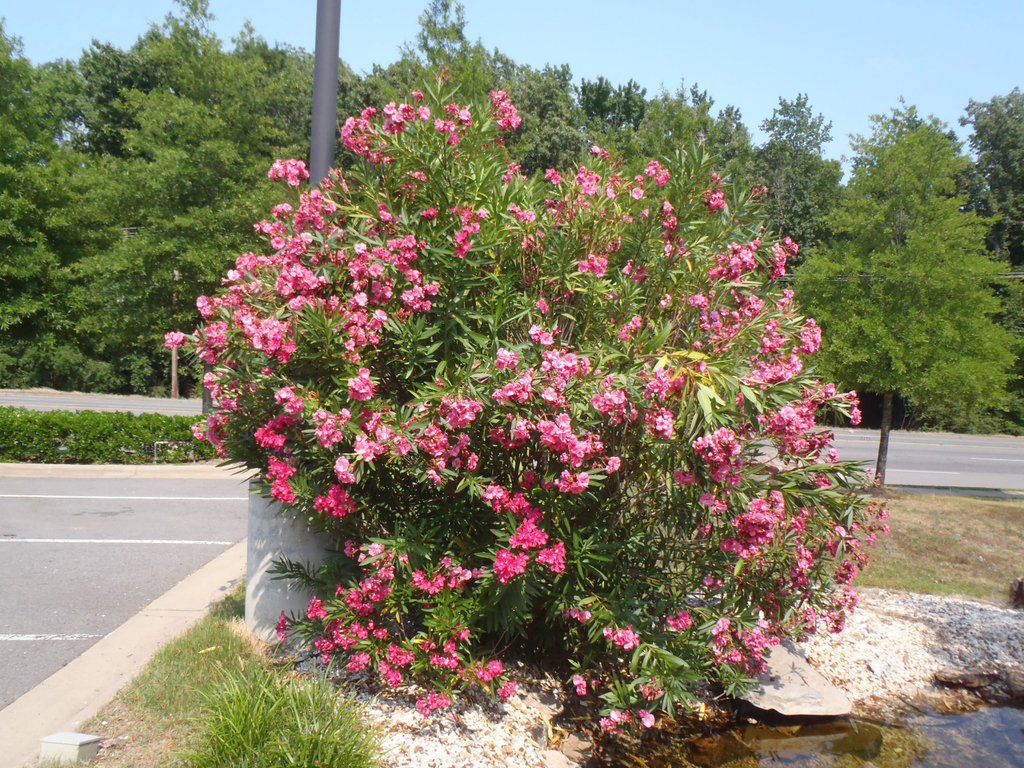

In [ ]:
# view an example image
from PIL import Image
Image.open('Test/Others/Images/Test00001.png')

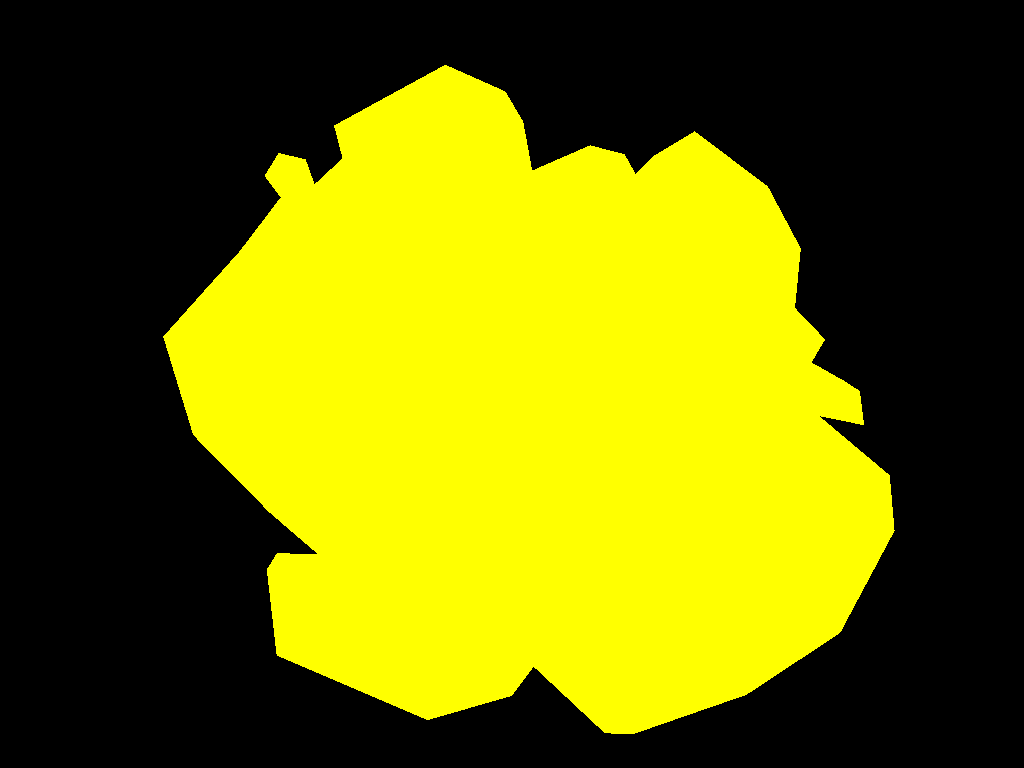

In [ ]:
# view the mask of the example image
mask = Image.open('Test/Oleander/Masks/Test00001_mask.png').convert('L')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 255, 0, # label is yellow
])
mask

In [ ]:
# define the dataset
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class NNDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to 
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "Masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        mask_path = os.path.join(self.root, "Masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # convert masks to grayscale mode to distinguish background and objects
        mask = Image.open(mask_path).convert("L")

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
# import Mask R-CNN architecture for fine-tuning
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 16471 (delta 59), reused 18 (delta 0), pack-reused 16386
Receiving objects: 100% (16471/16471), 16.32 MiB | 16.58 MiB/s, done.
Resolving deltas: 100% (11818/11818), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
# determine the version of cuda
!cat /usr/local/cuda/version.txt

CUDA Version 10.1.243


In [ ]:
# import helper functions
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = NNDataset('Test/Oleander', get_transform(train=True))
dataset_test = NNDataset('Test/Oleander', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-5])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-5:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
# train for 2 epochs
# small dataset therefore few epochs to avoid overfitting
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 1 iteration
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [0/1]  eta: 0:00:01  lr: 0.005000  loss: 4.6295 (4.6295)  loss_classifier: 0.8144 (0.8144)  loss_box_reg: 0.1303 (0.1303)  loss_mask: 3.6510 (3.6510)  loss_objectness: 0.0083 (0.0083)  loss_rpn_box_reg: 0.0256 (0.0256)  time: 1.2911  data: 0.6516  max mem: 2161
Epoch: [0] Total time: 0:00:01 (1.3533 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:00:04  model_time: 0.4714 (0.4714)  evaluator_time: 0.2068 (0.2068)  time: 0.8804  data: 0.1988  max mem: 2161
Test:  [4/5]  eta: 0:00:00  model_time: 0.4626 (0.4234)  evaluator_time: 0.3983 (0.3327)  time: 0.8096  data: 0.0437  max mem: 2161
Test: Total time: 0:00:04 (0.8209 s / it)
Averaged stats: model_time: 0.4626 (0.4234)  evaluator_time: 0.3983 (0.3327)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDet

In [ ]:
# test
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
  
prediction

[{'boxes': tensor([[263.5103,  97.6178, 864.3923, 600.0000],
          [ 38.7383, 115.9669, 608.3210, 600.0000],
          [542.3026, 136.8710, 821.1105, 600.0000],
          [399.3076, 232.4251, 900.0000, 551.6904],
          [  0.0000,  24.9209, 244.5384, 539.4071],
          [ 15.9383, 383.9549, 623.6639, 594.2341],
          [493.3971,  33.9220, 892.1841, 513.4369],
          [ 21.2425, 288.4044, 641.7911, 536.9144],
          [345.5477, 152.4727, 642.8477, 600.0000],
          [312.1420,  16.3686, 575.1172, 517.2966],
          [439.8372,  80.0001, 727.2758, 596.2084],
          [347.6212, 382.0185, 885.6733, 593.8145],
          [106.6603,  77.2534, 357.8742, 539.8763],
          [  6.6475, 232.1242, 457.5280, 496.7984],
          [340.5737,   0.0000, 822.2963, 374.8571],
          [202.1589, 144.2482, 482.0274, 600.0000],
          [  7.2863, 128.4099, 579.4418, 340.3005],
          [120.8888, 183.9287, 736.5146, 412.2972]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1

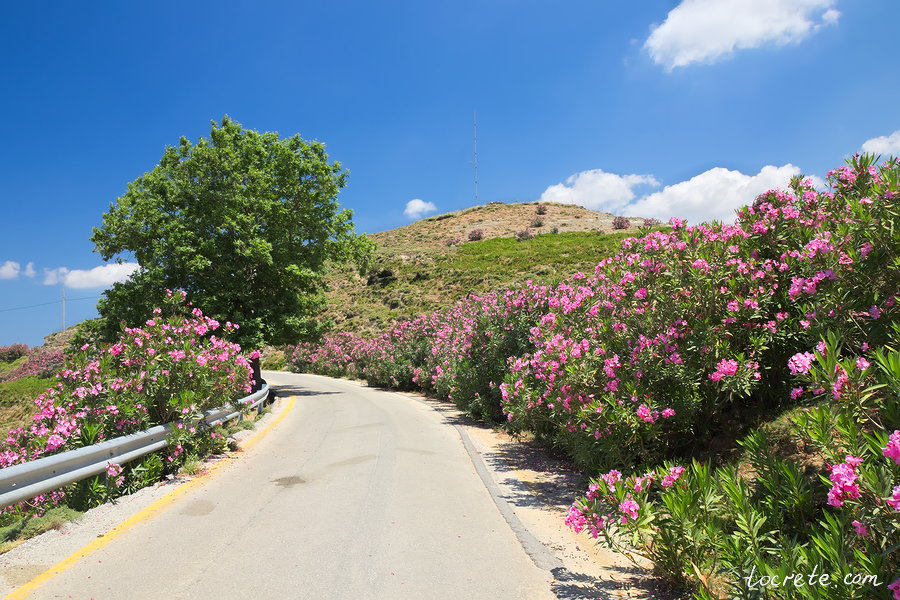

In [ ]:
# view verification image
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

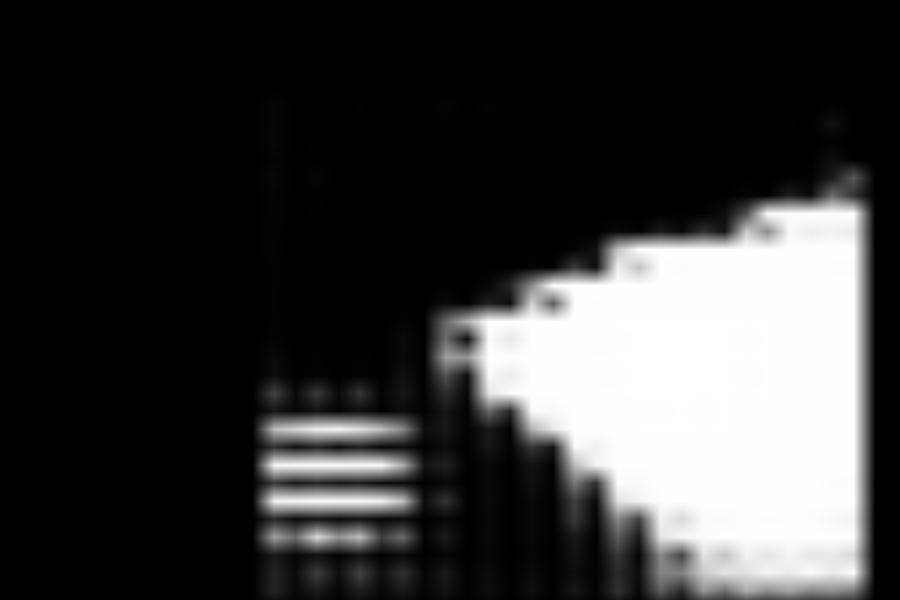

In [ ]:
# view prediction
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())